# Testing SWIPER-SIM simulation and 3D plotting functionality

In [1]:
import os
try:
    path_initialized
except NameError:
    path_initialized = True
    os.chdir('..')

from swiper.lattice_surgery_schedule import LatticeSurgerySchedule
from swiper.schedule_experiments import MemorySchedule, RegularTSchedule, MSD15To1Schedule, RandomTSchedule
from swiper.device_manager import DeviceManager
from swiper.window_builder import WindowBuilder
from swiper.window_manager import SlidingWindowManager
from swiper.decoder_manager import DecoderManager
from swiper.simulator import DecodingSimulator
import swiper.plot as plotter
import pickle
import json

import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.animation as animation

In [2]:
def draw_dag(G):
    for layer, nodes in enumerate(nx.topological_generations(G)):
        # `multipartite_layout` expects the layer as a node attribute, so add the
        # numeric layer value as a node attribute
        for node in nodes:
            G.nodes[node]["layer"] = layer

    # Compute the multipartite_layout using the "layer" node attribute
    pos = nx.multipartite_layout(G, subset_key="layer")

    nx.draw_networkx(G, pos=pos)

In [3]:
scheduling_method = 'sliding'

In [4]:
schedule = LatticeSurgerySchedule(True)
schedule.idle([(0,0)], 15)
schedule.inject_T([(1,0)])
idx = schedule.merge([(0,0), (1,0)])
schedule.discard([(1,0)])
schedule.Y_meas((0,0), idx)
schedule.discard([(0,0)])

## RegularTSchedule

In [5]:
simulator = DecodingSimulator()
success, sim_params, device_data, window_data, decoding_data = simulator.run(
    schedule=RegularTSchedule(10, 0).schedule,
    distance=7,
    scheduling_method='parallel',
    decoding_latency_fn=lambda x: 7,
    speculation_mode='separate',
    speculation_latency=1,
    speculation_accuracy=0.9,
    max_parallel_processes='predict',
    progress_bar=True,
    rng=0,
    lightweight_setting=0,
)

PREDICTION STEP BEGIN---------------------------------
Predicted max parallel processes: 6

PREDICTION STEP END-----------------------------------



Surface code rounds: 415it [00:00, 19377.87it/s]


In [6]:
simulator._device_manager._conditional_S_locations

[((0, 0), 28),
 ((0, 0), 76),
 ((0, 0), 98),
 ((0, 0), 126),
 ((0, 0), 148),
 ((0, 0), 196),
 ((0, 0), 244),
 ((0, 0), 292),
 ((0, 0), 346),
 ((0, 0), 394)]

In [7]:
device_data.num_rounds

407

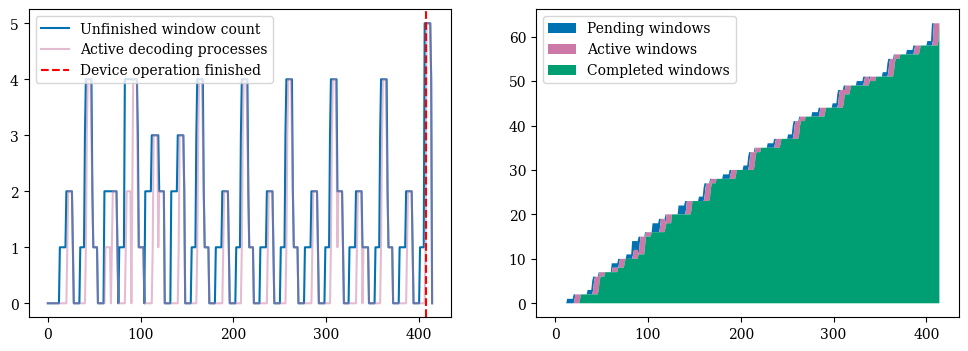

In [9]:
fig,ax = plt.subplots(1,2, figsize=(12,4))

window_count_history = np.zeros((decoding_data.num_rounds), dtype=int)
for round in window_data.window_construction_times.values():
    window_count_history[round:] += 1
ax[0].plot(range(decoding_data.num_rounds), np.array(window_count_history) - np.array(decoding_data.completed_windows_by_round), label='Unfinished window count')
ax[0].plot(range(decoding_data.num_rounds), decoding_data.decode_processes_by_round, alpha=0.5, label='Active decoding processes')
ax[0].axvline(x=device_data.num_rounds, color='r', linestyle='--', label='Device operation finished')
ax[0].legend()

ax[1].fill_between(range(decoding_data.num_rounds), np.array(decoding_data.completed_windows_by_round)+np.array(decoding_data.decode_processes_by_round), window_count_history, label='Pending windows')
ax[1].fill_between(range(decoding_data.num_rounds), decoding_data.completed_windows_by_round, np.array(decoding_data.completed_windows_by_round) + np.array(decoding_data.decode_processes_by_round), label='Active windows')
ax[1].fill_between(range(decoding_data.num_rounds), 0, decoding_data.completed_windows_by_round, label='Completed windows')
ax[1].legend()

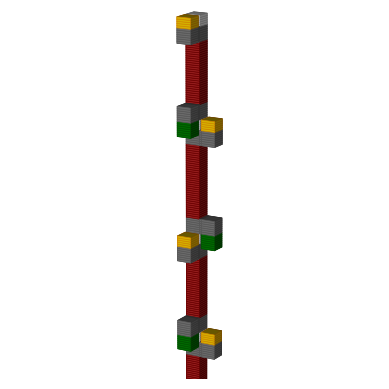

In [10]:
ax = plotter.plot_device_schedule_trace(device_data, spacing=1, z_min=120)
ax.set_axis_off()
plt.savefig('notebooks/figures/random_t.png', bbox_inches='tight', dpi=300)

<Axes3D: >

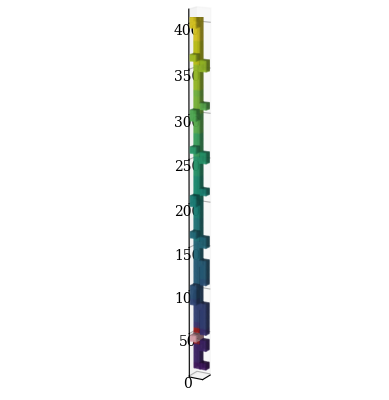

In [11]:
plotter.plot_windows(
    device_data=device_data,
    window_data=window_data,
    decoder_data=decoding_data,
    window_buffers_to_highlight=[7, 6],
    spacing=1,
)

## 15 - 1 Factory

In [12]:
# speculation_mode, scheduling_method = 'separate', 'aligned'
speculation_mode, scheduling_method = None, 'parallel'

In [13]:
simulator = DecodingSimulator()
success, _, device_data, window_data, decoding_data = simulator.run(
    schedule=MSD15To1Schedule().schedule,
    distance=7,
    scheduling_method=scheduling_method,
    decoding_latency_fn=lambda x: 14,
    speculation_mode=speculation_mode,
    speculation_latency=1,
    speculation_accuracy=0.9,
    poison_policy='successors',
    max_parallel_processes=None,
    progress_bar=True,
    rng=0,
    lightweight_setting=0,
)
print(device_data.num_rounds, decoding_data.num_rounds)

Surface code rounds: 129it [00:00, 2247.98it/s]

106 129


In [14]:
len(simulator._window_manager.all_windows)

253

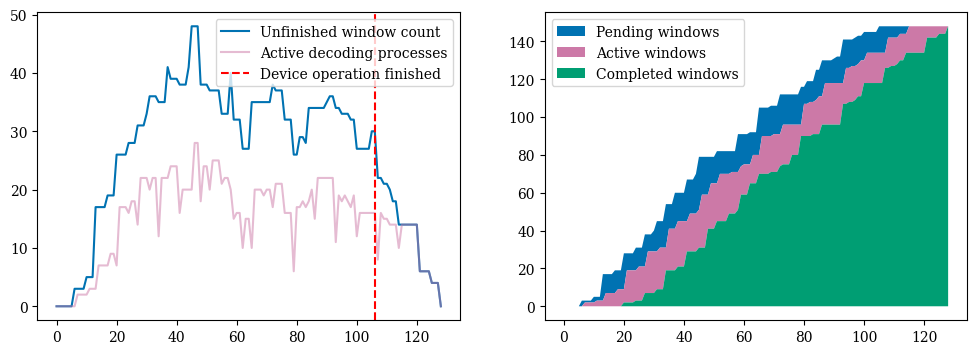

In [15]:
fig,ax = plt.subplots(1,2, figsize=(12,4))

window_count_history = np.zeros((decoding_data.num_rounds), dtype=int)
for round in window_data.window_construction_times.values():
    window_count_history[round:] += 1
ax[0].plot(range(decoding_data.num_rounds), np.array(window_count_history) - np.array(decoding_data.completed_windows_by_round), label='Unfinished window count')
ax[0].plot(range(decoding_data.num_rounds), decoding_data.decode_processes_by_round, alpha=0.5, label='Active decoding processes')
ax[0].axvline(x=device_data.num_rounds, color='r', linestyle='--', label='Device operation finished')
ax[0].legend()

ax[1].fill_between(range(decoding_data.num_rounds), np.array(decoding_data.completed_windows_by_round)+np.array(decoding_data.decode_processes_by_round), window_count_history, label='Pending windows')
ax[1].fill_between(range(decoding_data.num_rounds), decoding_data.completed_windows_by_round, np.array(decoding_data.completed_windows_by_round) + np.array(decoding_data.decode_processes_by_round), label='Active windows')
ax[1].fill_between(range(decoding_data.num_rounds), 0, decoding_data.completed_windows_by_round, label='Completed windows')
ax[1].legend()

106


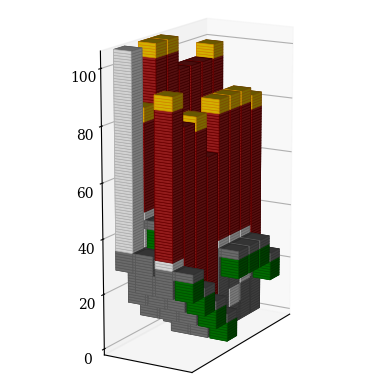

In [16]:
ax = plotter.plot_device_schedule_trace(device_data, spacing=1, z_max=106)
# plt.title(f'{scheduling_method} ({decoding_data.num_rounds} rounds)')
print(device_data.num_rounds)
# ax.set_zlim(0,106)
if speculation_mode:
    plt.savefig(f'notebooks/figures/MSD_{scheduling_method}_spec.png', bbox_inches='tight', dpi=300)
else:
    plt.savefig(f'notebooks/figures/MSD_{scheduling_method}_nospec.png', bbox_inches='tight', dpi=300)

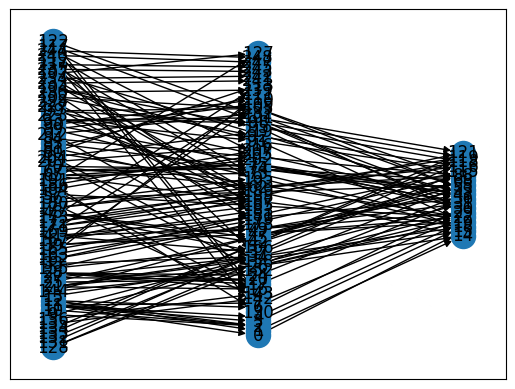

In [17]:
draw_dag(nx.DiGraph(window_data.window_dag_edges))

<Axes3D: >

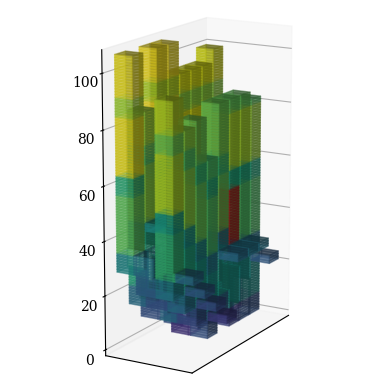

In [18]:
selected_window_idx_1 = -1
for i in window_data.all_constructed_windows:
    window = window_data.get_window(i)
    if selected_window_idx_1 >= 0:
        break
    for cr in window.commit_region:
        if cr.patch == (3,3):
            selected_window_idx_1 = i
            break

selected_window_idx_2 = -1
for i in window_data.all_constructed_windows:
    window = window_data.get_window(i)
    if selected_window_idx_2 >= 0:
        break
    for cr in window.commit_region:
        if cr.patch == (2,7) and cr.duration == 3:
            selected_window_idx_2 = i
            break

plotter.plot_windows(
    device_data=device_data,
    window_data=window_data,
    decoder_data=decoding_data,
    window_buffers_to_highlight=[selected_window_idx_1, selected_window_idx_2],
    spacing=1,
)

In [19]:
simulator = DecodingSimulator()
success, _, device_data, window_data, decoding_data = simulator.run(
    schedule=RegularTSchedule(1, 10).schedule,
    distance=7,
    scheduling_method='sliding',
    decoding_latency_fn=lambda x: 14,
    speculation_mode=None,
    speculation_latency=1,
    speculation_accuracy=0.9,
    max_parallel_processes=None,
    progress_bar=True,
    rng=0,
    lightweight_setting=0,
)

Surface code rounds: 165it [00:00, 17441.91it/s]


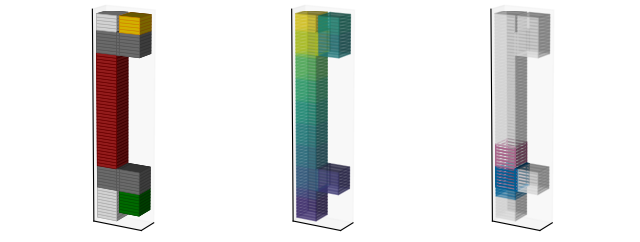

In [20]:
fig = plt.figure(figsize=(8,8))
ax0 = fig.add_subplot(1,3,1, projection='3d')
ax1 = fig.add_subplot(1,3,2, projection='3d')
ax2 = fig.add_subplot(1,3,3, projection='3d')

plotter.plot_device_schedule_trace(device_data, ax=ax0, hide_z_ticks=True)

plotter.plot_windows(
    ax=ax1,
    device_data=device_data,
    window_data=window_data,
    decoder_data=decoding_data,
    window_buffers_to_highlight=[],
    hide_z_ticks=True,
)

plotter.plot_windows(
    ax=ax2,
    device_data=device_data,
    window_data=window_data,
    decoder_data=decoding_data,
    window_buffers_to_highlight=[1,3],
    window_cmap=None,
    selected_window_colors=['C0', 'C1', 'C2'],
    hide_z_ticks=True,
)

ax0.set_aspect('equal')
ax1.set_zlim(ax0.get_zlim())
ax1.set_aspect('equal')
ax2.set_zlim(ax0.get_zlim())
ax2.set_aspect('equal')

fig.subplots_adjust(wspace=-0.1)
plt.savefig('inject_t_pipes.svg', dpi=300, bbox_inches='tight')
plt.savefig('inject_t_pipes.pdf', dpi=300, bbox_inches='tight')

# Stress test

In [21]:
schedule=RandomTSchedule(1000, 100, 0).schedule

In [22]:
%%prun
simulator = DecodingSimulator()
success, sim_params, device_data, window_data, decoding_data = simulator.run(
    schedule=schedule,
    distance=7,
    scheduling_method='parallel',
    decoding_latency_fn=lambda x: 14,
    speculation_mode='separate',
    speculation_latency=1,
    speculation_accuracy=0.7,
    max_parallel_processes=None,
    progress_bar=True,
    rng=0,
    lightweight_setting=2,
)

print(device_data.num_rounds, decoding_data.num_rounds)

Failed to get source of decoding_latency_fn: could not get source code


Surface code rounds: 101683it [00:14, 6870.67it/s]

101668 101683
 

         53819025 function calls (50497601 primitive calls) in 15.776 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
1011737/101671    1.075    0.000    2.394    0.000 copy.py:128(deepcopy)
   269368    1.042    0.000    4.243    0.000 device_manager.py:222(_predict_instruction_start_time_fully)
  1418837    0.999    0.000    1.404    0.000 device_manager.py:160(_predict_instruction_start_time)
   198857    0.581    0.000    1.911    0.000 window_manager.py:240(count_covered_faces)
   101668    0.537    0.000    0.997    0.000 window_builder.py:220(build_windows)
   101683    0.529    0.000    1.649    0.000 decoder_manager.py:134(step)
6684296/4960959    0.517    0.000    0.844    0.000 {built-in method builtins.len}
  1418837    0.431    0.000    0.591    0.000 device_manager.py:58(add)
   101683    0.410    0.000   14.602    0.000 simulator.py:290(step_experiment)
  1418837    0.394    0.000    0.583    0.000 device_man

In [23]:
sim_params.to_dict()

{'distance': 7,
 'scheduling_method': 'parallel',
 'decoding_latency_fn': None,
 'speculation_mode': 'separate',
 'speculation_latency': 1,
 'speculation_accuracy': 0.7,
 'poison_policy': 'successors',
 'missed_speculation_modifier': 1.4,
 'max_parallel_processes': None,
 'lightweight_setting': 2,
 'rng': 0,
 'pending_window_count_cutoff': 0,
 'device_rounds_cutoff': 0,
 'clock_timeout_seconds': None,
 'processor_prediction_results': {}}